In [1]:
import feather, math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import scipy
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
%matplotlib inline

### Load in data from previous notebook

In [2]:
%time interp_data = pd.read_feather('tmp_data/interp_data')
%time model_data = pd.read_feather('tmp_data/model_data')
X,y = model_data.drop('SalePrice',axis=1), model_data['SalePrice']

CPU times: user 225 ms, sys: 143 ms, total: 368 ms
Wall time: 617 ms
CPU times: user 89.2 ms, sys: 153 ms, total: 242 ms
Wall time: 541 ms


### Train/Test Split
#### Since this is predicting on future sales, we will put the validation set on the most recent data

In [3]:
#Train/Test function
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

# Determining data sizes
n_test = 12000  # same as Kaggle's test set size
n_train = len(X)-n_test

#Split 
interp_train, interp_test = split_vals(interp_data, n_train)
X_train, X_test = split_vals(X, n_train)
y_train, y_test = split_vals(y, n_train)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((389125, 66), (389125,), (12000, 66), (12000,))

### Metrics to measure training data score and test data scores

In [4]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    train_err = rmse(m.predict(X_train), y_train)
    train_score = m.score(X_train, y_train)
    test_err = rmse(m.predict(X_test), y_test)
    test_score =  m.score(X_test, y_test)
    print('Train RMSE: {}, Train Accuracy: {}'.format(train_err,train_score))
    print('Validation RMSE: {}, Validation Accuracy: {}'.format(test_err,test_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [5]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 47s, sys: 1.57 s, total: 1min 49s
Wall time: 41.4 s
Train RMSE: 3049.3640510459004, Train Accuracy: 0.9824187414838048
Validation RMSE: 8291.387885797478, Validation Accuracy: 0.8830846863965632


### Tuning Hyperparameters

In [6]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Train RMSE: 4047.1746378698413, Train Accuracy: 0.9690304213009235
Validation RMSE: 7663.959126223039, Validation Accuracy: 0.9001097055542194
OOB Score: 0.9095502989681427


### Taking subsamples

In [7]:
# from sklearn.ensemble import forest

# def set_rf_samples(n):
#     """ Changes Scikit learn's random forests to give each tree a random sample of
#     n random rows.
#     """
#     forest._generate_sample_indices = (lambda rs, n_samples:
#         forest.check_random_state(rs).randint(0, n_samples, n))

# def reset_rf_samples():
#     """ Undoes the changes produced by set_rf_samples.
#     """
#     forest._generate_sample_indices = (lambda rs, n_samples:
#         forest.check_random_state(rs).randint(0, n_samples, n_samples))

#################################################################################
##################################### OR ########################################
#################################################################################

# def df_subsample(df,n):
#     idxs = sorted(np.random.permutation(len(df))[:n])
#     return df.iloc[idxs].copy()

# model_subsample = df_subsample(model_data,70000)
# X,y = model_subsample.drop('SalePrice',axis=1), model_subsample['SalePrice']
# X_train, X_valid = split_vals(X, 60000)
# y_train, y_valid = split_vals(y, 60000)

# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

## Feature Importance

How Does Feature Importance Work?:

In [8]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'importance', 'barh', figsize=(12,7), legend=False)

In [9]:
feat_imp_df = rf_feat_importance(m,X_train)
feat_imp_df[:10]

,cols,importance
5,YearMade,0.198499
13,ProductSize,0.153924
10,fiSecondaryDesc,0.073406
65,saleElapsed,0.062659
19,Enclosure,0.061037
14,fiProductClassDesc,0.054633
2,ModelID,0.048896
8,fiModelDesc,0.041578
9,fiBaseModel,0.038865
0,SalesID,0.030490


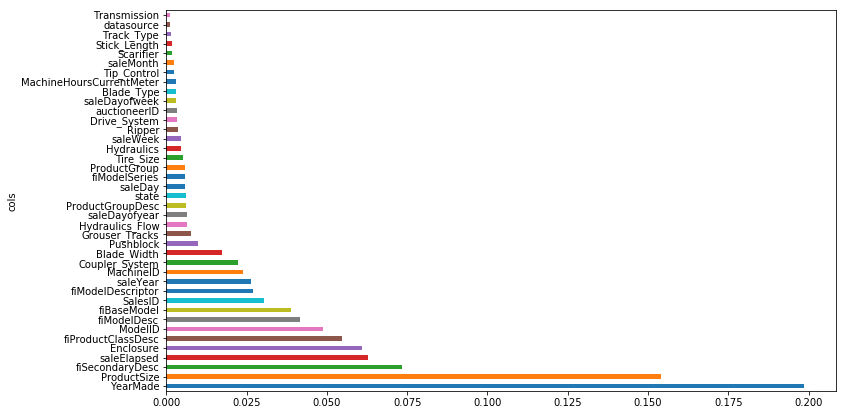

In [10]:
plot_fi(feat_imp_df[:40]);

In [11]:
to_keep = feat_imp_df[feat_imp_df.importance>0.005].cols
len(to_keep)

25

### Reassigning Train/Test sets to updated values

In [12]:
df_keep = X[to_keep].copy()
X_train, X_test = split_vals(df_keep, n_train)

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMSE: 4252.949363887945, Train Accuracy: 0.9658011240678203
Validation RMSE: 7538.406305776544, Validation Accuracy: 0.9033557508415607
OOB Score: 0.9076866852467204


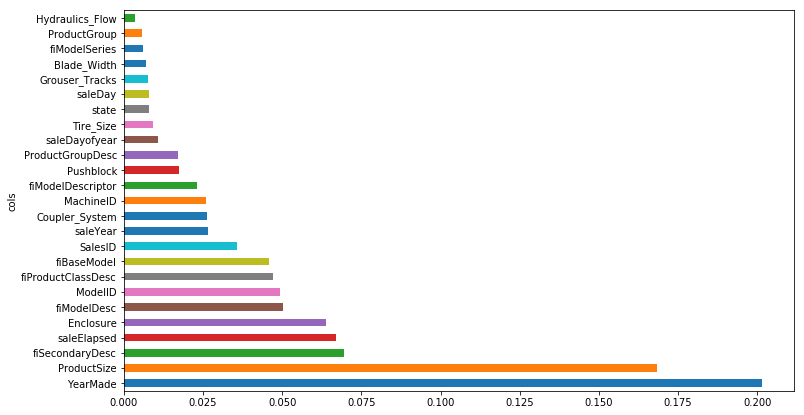

In [14]:
fi2 = rf_feat_importance(m, df_keep)
plot_fi(fi2);

## Removing Redundant Features

### Using Hierarchical Clustering to find nearest features

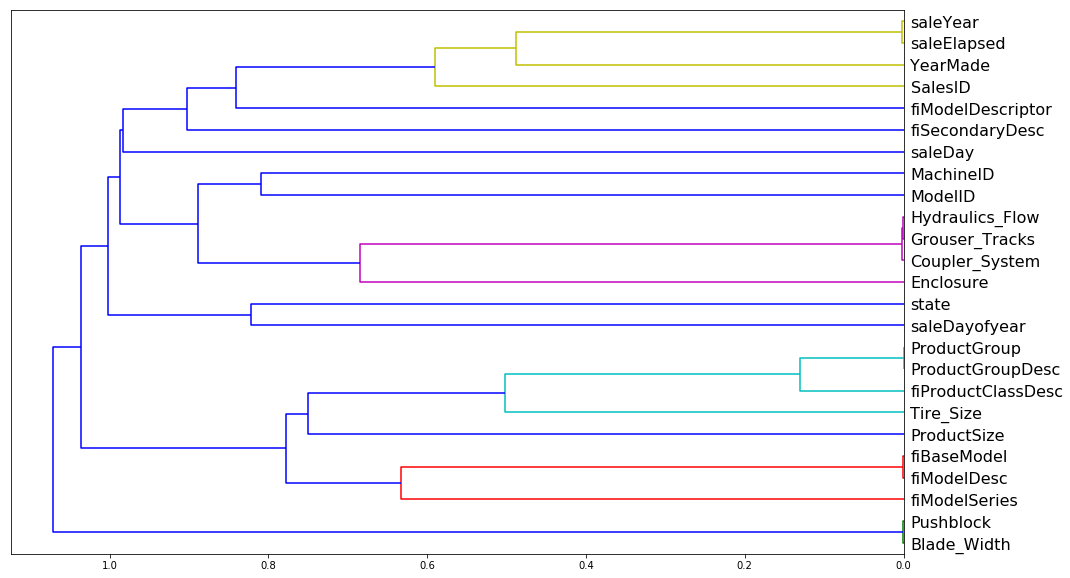

In [15]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

### How does removing these features affect our score?

In [16]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_train)
    m.fit(x, y_train)
    return m.oob_score_

In [17]:
%time get_oob(df_keep)

CPU times: user 1min 47s, sys: 1.39 s, total: 1min 48s
Wall time: 36.3 s


0.9037682318215563

In [22]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

/Users/Chris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleYear 0.9029137614566559
saleElapsed 0.9000188888829994
fiModelDesc 0.9029593106325493


/Users/Chris/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


fiBaseModel 0.9037389247702735
Grouser_Tracks 0.9037473580087669
Coupler_System 0.9028478450078731


In [23]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.9026644634679775

### It appears removing these features doesn't affect our scores

In [40]:
X_train, X_test = split_vals(df_keep, n_train)

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train RMSE: 4277.500141435522, Train Accuracy: 0.9654051483311104
Validation RMSE: 7633.332966750599, Validation Accuracy: 0.9009064591506672
OOB Score: 0.9055420014909481


In [27]:
# df_keep.drop(to_drop, axis=1, inplace=True)
# df_keep.to_feather('tmp_data/features_trimmed')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 22 columns):
YearMade              401125 non-null int64
ProductSize           401125 non-null int8
fiSecondaryDesc       401125 non-null int16
saleElapsed           401125 non-null int64
Enclosure             401125 non-null int8
fiProductClassDesc    401125 non-null int8
ModelID               401125 non-null int64
fiModelDesc           401125 non-null int16
SalesID               401125 non-null int64
fiModelDescriptor     401125 non-null int16
MachineID             401125 non-null int64
Coupler_System        401125 non-null int8
Blade_Width           401125 non-null int8
Pushblock             401125 non-null int8
Hydraulics_Flow       401125 non-null int8
saleDayofyear         401125 non-null int64
ProductGroupDesc      401125 non-null int8
state                 401125 non-null int8
saleDay               401125 non-null int64
fiModelSeries         401125 non-null int8
ProductGroup       

In [29]:
df_keep = pd.read_feather('tmp_data/features_trimmed')

## Phase 3:
### Test Model on Get Dummies to find important predictors within a category
### Use Partial Dependency Plots
### Perform Prediction Explanations